In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyodbc
from datetime import datetime
from dotenv import load_dotenv
import os
from sqlalchemy import create_engine

In [2]:
# Cargar las variables de entorno desde el archivo .env
load_dotenv()

# Obtener las credenciales del .env
server = os.getenv("DB_SERVER")
database = os.getenv("DB_DATABASE")
username = os.getenv("DB_USERNAME")
password = os.getenv("DB_PASSWORD")
driver = os.getenv("DB_DRIVER", "ODBC Driver 17 for SQL Server")

# Crear la cadena de conexión para SQL Server
connection_string = f"mssql+pyodbc://{username}:{password}@{server}/{database}?driver={driver}"

# Crear el engine para SQLAlchemy
engine = create_engine(connection_string)

In [3]:
df = pd.read_csv('ventas_tienda_online.csv', encoding='utf-8')

# Definir el formato de fecha conocido
date_format = '%d/%m/%y'

# Convertir de forma genérica las columnas de fecha (si en el nombre aparece "date" o "fecha")
for col in df.columns:
    if 'date' in col.lower() or 'fecha' in col.lower():
        df[col] = pd.to_datetime(df[col], format=date_format, errors='coerce')

# Eliminar registros duplicados
df = df.drop_duplicates()



# Mostrar resumen del DataFrame para validar las conversiones y la presencia de NaN
print("Información del DataFrame:")
print(df.info())
print("\nPrimeras filas:")
print(df.head())

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 0 to 10001
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   order_id          10000 non-null  int64         
 1   purchase_date     10000 non-null  datetime64[ns]
 2   customer_id       10000 non-null  int64         
 3   customer_gender   9996 non-null   object        
 4   customer_age      9998 non-null   float64       
 5   product_category  9998 non-null   object        
 6   product_name      9984 non-null   object        
 7   product_price     9999 non-null   float64       
 8   quantity          10000 non-null  int64         
 9   order_total       10000 non-null  float64       
 10  payment_method    9998 non-null   object        
 11  shipping_region   10000 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(3), object(5)
memory usage: 1015.6+ KB
None

Primeras filas:
   orde

In [4]:
# Cargar los datos a la base de datos SQL (si la tabla ya existe, se reemplaza)
df.to_sql('ventas_tienda_online', engine, if_exists='replace', index=False)

print("Datos cargados a la base de datos exitosamente!")

Datos cargados a la base de datos exitosamente!


In [5]:
# Consultar todos los datos de la tabla
query = "SELECT * FROM ventas_tienda_online"
data_db = pd.read_sql(query, engine)
data_db.head()
# Calcular estadísticas básicas para variables numéricas
print(data_db.describe())

          order_id               purchase_date   customer_id  customer_age  \
count  10000.00000                       10000  10000.000000   9998.000000   
mean    5000.50000  2023-07-01 23:43:26.400000    504.470600     48.332366   
min        1.00000         2023-01-01 00:00:00      1.000000     18.000000   
25%     2500.75000         2023-04-02 00:00:00    251.000000     33.000000   
50%     5000.50000         2023-07-02 00:00:00    506.500000     48.000000   
75%     7500.25000         2023-10-02 00:00:00    758.000000     64.000000   
max    10000.00000         2023-12-31 00:00:00   1000.000000     79.000000   
std     2886.89568                         NaN    289.724434     17.908564   

       product_price      quantity   order_total  
count    9999.000000  10000.000000  10000.000000  
mean      104.886448      2.999500    314.509017  
min        10.010000      1.000000     10.070000  
25%        57.890000      2.000000    127.400000  
50%       104.840000      3.000000    254.

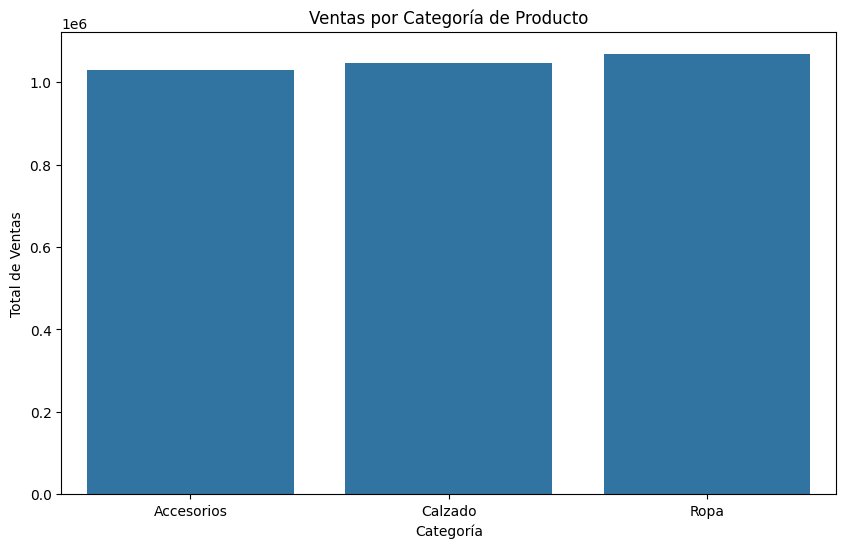

In [6]:
# Agrupar por categoría y sumar el total de la orden
ventas_categoria = data_db.groupby('product_category')['order_total'].sum().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x='product_category', y='order_total', data=ventas_categoria)
plt.title('Ventas por Categoría de Producto')
plt.xlabel('Categoría')
plt.ylabel('Total de Ventas')
plt.show()


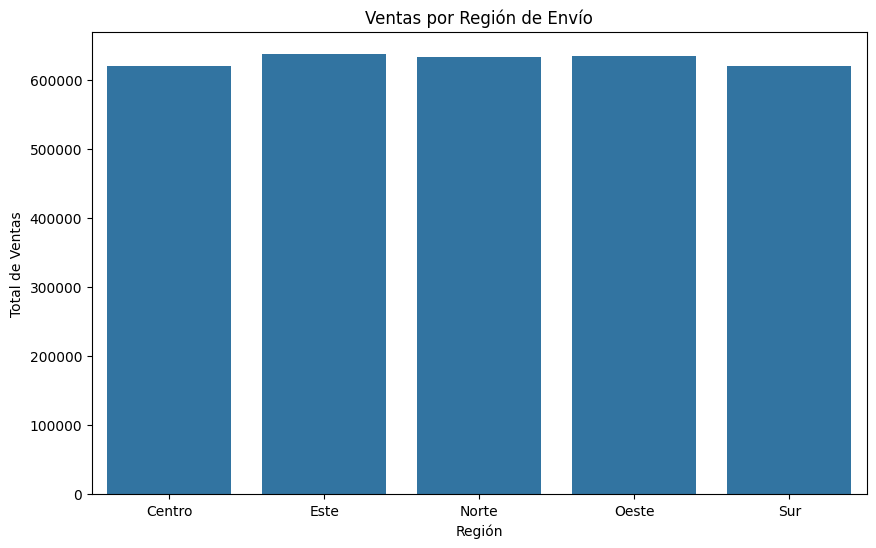

In [7]:
ventas_region = data_db.groupby('shipping_region')['order_total'].sum().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x='shipping_region', y='order_total', data=ventas_region)
plt.title('Ventas por Región de Envío')
plt.xlabel('Región')
plt.ylabel('Total de Ventas')
plt.show()

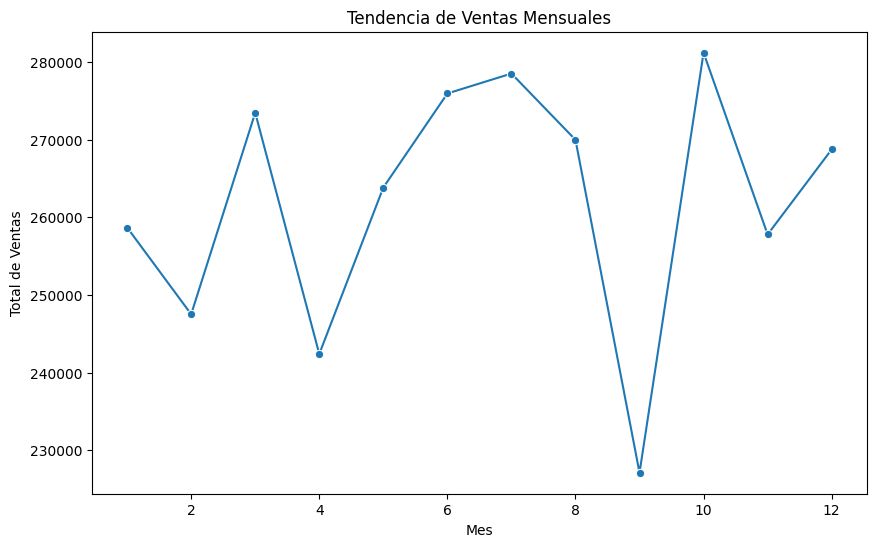

In [8]:
data_db['Mes'] = data_db['purchase_date'].dt.month
ventas_mes = data_db.groupby('Mes')['order_total'].sum().reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(x='Mes', y='order_total', data=ventas_mes, marker='o')
plt.title('Tendencia de Ventas Mensuales')
plt.xlabel('Mes')
plt.ylabel('Total de Ventas')
plt.show()

In [9]:
productos_ventas = data_db.groupby('product_name')['quantity'].sum().reset_index()
productos_ventas = productos_ventas.sort_values(by='quantity', ascending=False)
print("Productos más vendidos:\n", productos_ventas.head())

Productos más vendidos:
         product_name  quantity
11           Sweater      2152
4           Chaqueta      2119
6              Gorro      2046
14  Zapatos formales      2041
3           Camiseta      2034


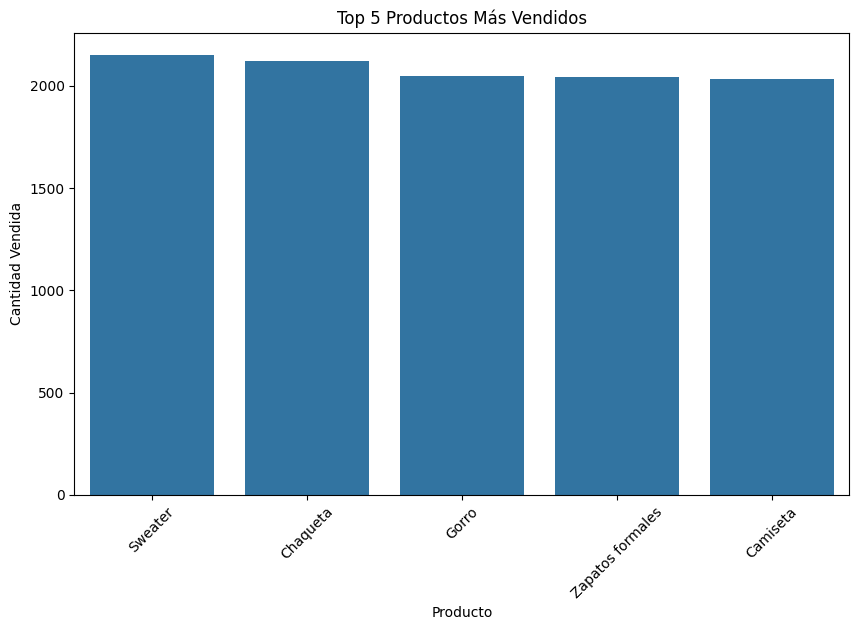

In [10]:
# Gráfico 4: Top 5 productos más vendidos
top5_productos = productos_ventas.head(5)
plt.figure(figsize=(10,6))
sns.barplot(x='product_name', y='quantity', data=top5_productos)
plt.title('Top 5 Productos Más Vendidos')
plt.xlabel('Producto')
plt.ylabel('Cantidad Vendida')
plt.xticks(rotation=45)
plt.show()

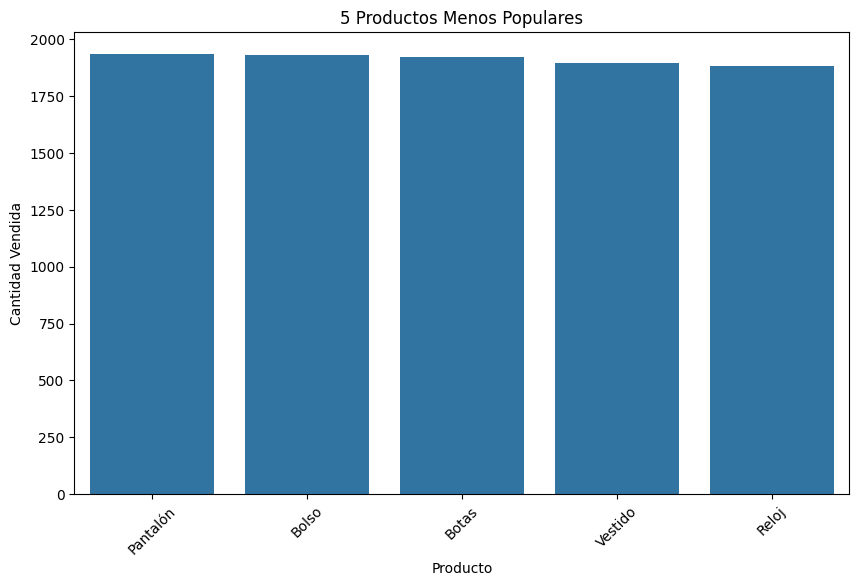

In [11]:
# Asumimos que los productos con menor cantidad vendida son los menos populares
menos_populares = productos_ventas.tail(5)
plt.figure(figsize=(10,6))
sns.barplot(x='product_name', y='quantity', data=menos_populares)
plt.title('5 Productos Menos Populares')
plt.xlabel('Producto')
plt.ylabel('Cantidad Vendida')
plt.xticks(rotation=45)
plt.show()

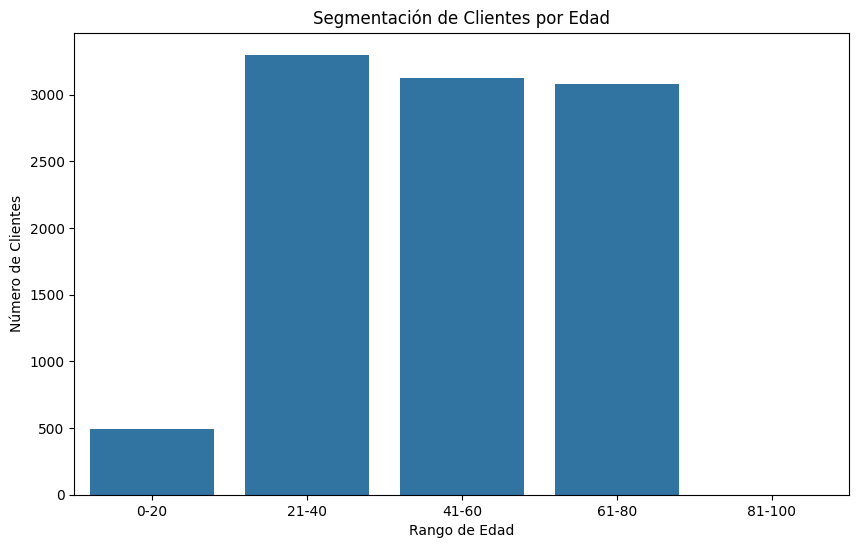

In [12]:
bins = [0, 20, 40, 60, 80, 100]
labels = ['0-20', '21-40', '41-60', '61-80', '81-100']
data_db['Rango de Edad'] = pd.cut(data_db['customer_age'], bins=bins, labels=labels)

plt.figure(figsize=(10,6))
sns.countplot(x='Rango de Edad', data=data_db)
plt.title('Segmentación de Clientes por Edad')
plt.xlabel('Rango de Edad')
plt.ylabel('Número de Clientes')
plt.show()

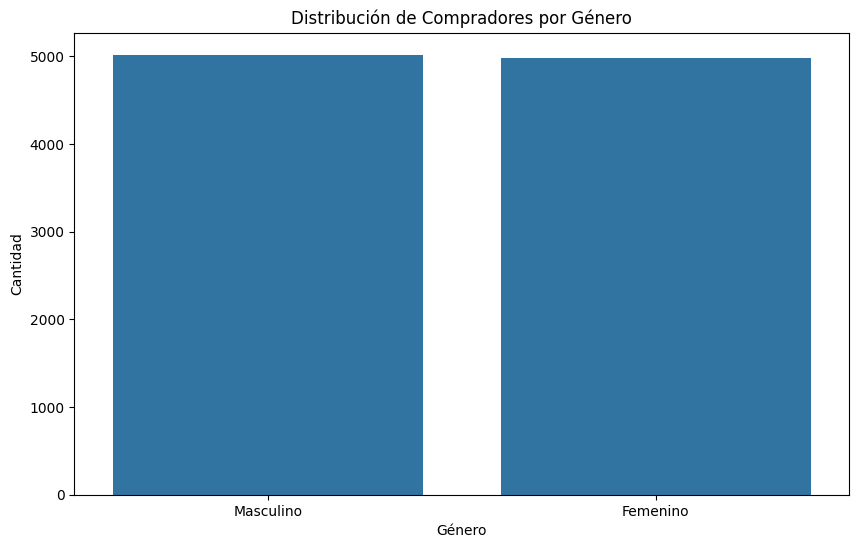

In [13]:
plt.figure(figsize=(10,6))
sns.countplot(x='customer_gender', data=data_db)
plt.title('Distribución de Compradores por Género')
plt.xlabel('Género')
plt.ylabel('Cantidad')
plt.show()

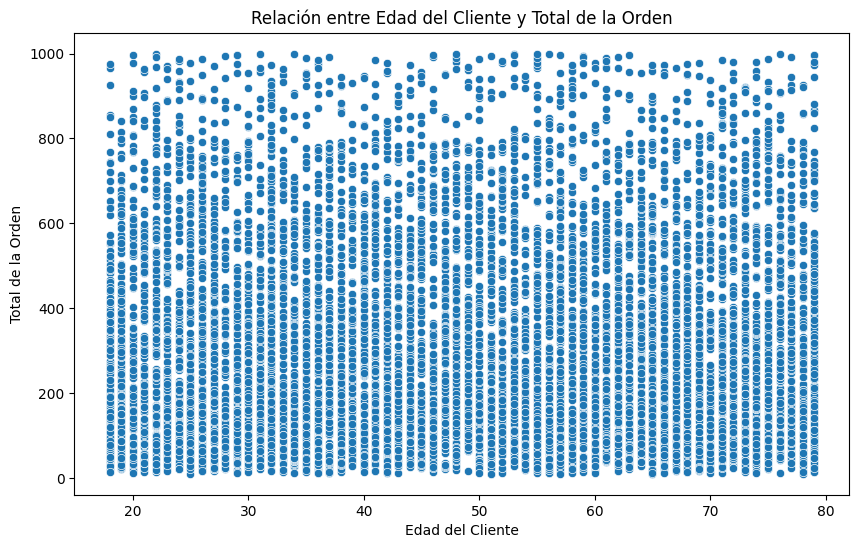

Coeficiente de correlación entre Edad y Total de la Orden: 0.009283719403814556


In [14]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='customer_age', y='order_total', data=data_db)
plt.title('Relación entre Edad del Cliente y Total de la Orden')
plt.xlabel('Edad del Cliente')
plt.ylabel('Total de la Orden')
plt.show()

# Calcular el coeficiente de correlación
corr_coef = data_db['customer_age'].corr(data_db['order_total'])
print("Coeficiente de correlación entre Edad y Total de la Orden:", corr_coef)

payment_method    Efectivo  PayPal  Tarjeta de crédito  Transferencia bancaria
product_category                                                              
Accesorios             820     809                 844                     837
Calzado                854     815                 788                     861
Ropa                   871     833                 816                     848


<Figure size 1000x600 with 0 Axes>

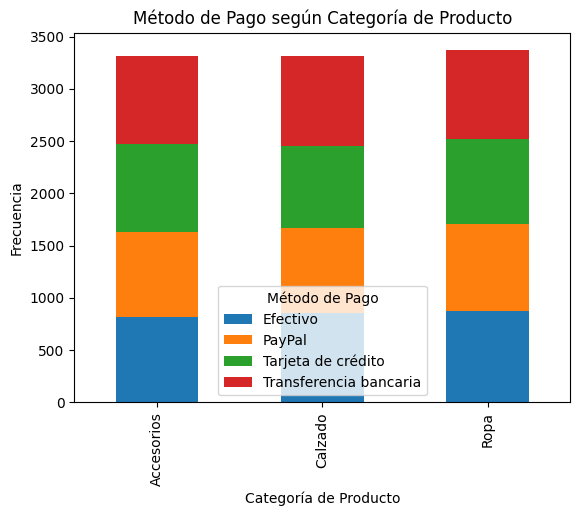

In [15]:
crosstab = pd.crosstab(data_db['product_category'], data_db['payment_method'])
print(crosstab)

plt.figure(figsize=(10,6))
crosstab.plot(kind='bar', stacked=True)
plt.title('Método de Pago según Categoría de Producto')
plt.xlabel('Categoría de Producto')
plt.ylabel('Frecuencia')
plt.legend(title='Método de Pago')
plt.show()

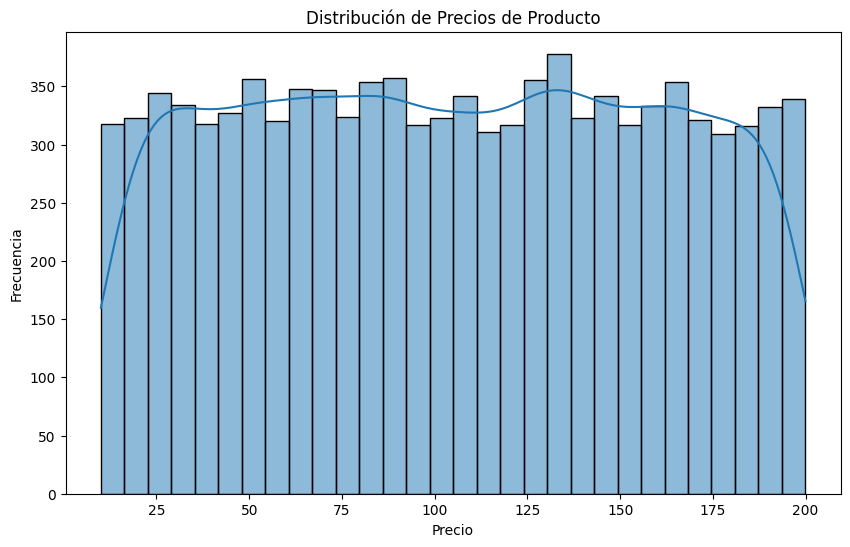

In [16]:
plt.figure(figsize=(10,6))
sns.histplot(data_db['product_price'], bins=30, kde=True)
plt.title('Distribución de Precios de Producto')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()

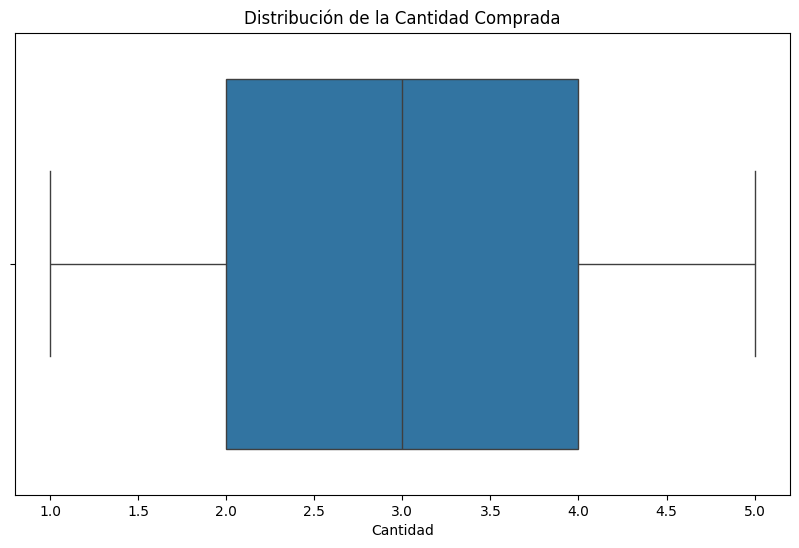

In [17]:
plt.figure(figsize=(10,6))
sns.boxplot(x=data_db['quantity'])
plt.title('Distribución de la Cantidad Comprada')
plt.xlabel('Cantidad')
plt.show()

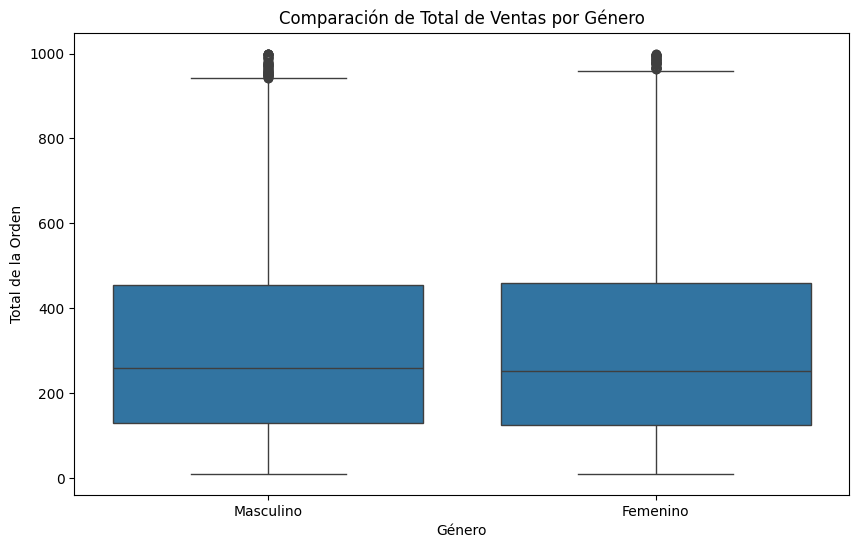

In [18]:
plt.figure(figsize=(10,6))
sns.boxplot(x='customer_gender', y='order_total', data=data_db)
plt.title('Comparación de Total de Ventas por Género')
plt.xlabel('Género')
plt.ylabel('Total de la Orden')
plt.show()